# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pydot
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

/opt/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [2]:
!ls PetImages


Cat Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [3]:
num_skipped = 0
print("here!")
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        if fname[-1].lower() == 'g':
            fpath = os.path.join(folder_path, fname)
            #Image.open(fpath).convert('L').save(fpath)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

print("Deleted %d images" % num_skipped)


here!
Deleted 0 images


## Generate a `Dataset`


In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    color_mode='grayscale',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    color_mode='grayscale',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


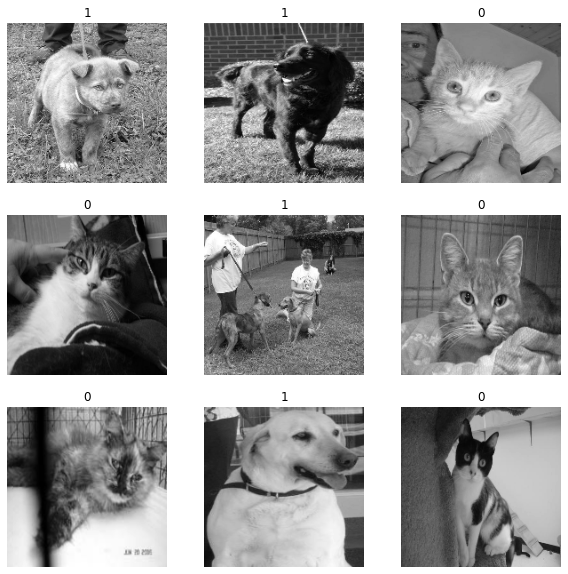

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8").squeeze()
        plt.imshow(img,cmap='gray', vmin=0, vmax=255)
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


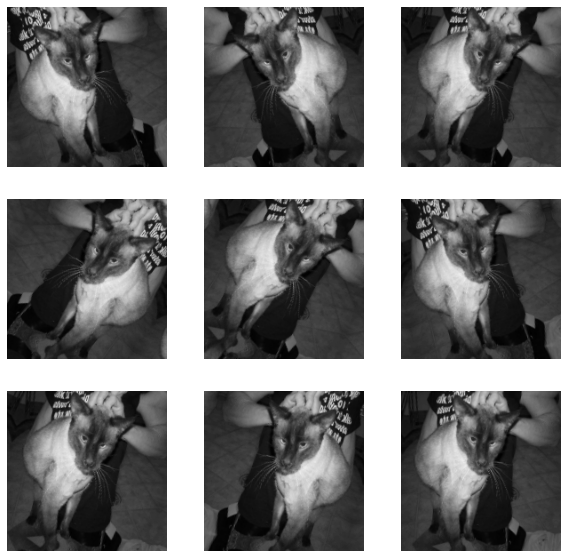

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[0].numpy().astype("uint8").squeeze()
        plt.imshow(img,cmap='gray', vmin=0, vmax=255)
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

We'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


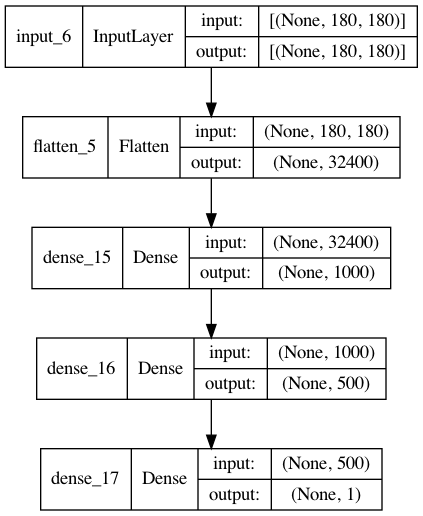

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    h1 = layers.Dense(1000)(x)
    h2 = layers.Dense(500, activation="relu")(h1)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = layers.Dense(units, activation=activation)(h2)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size, num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [21]:
epochs = 30

#callbacks = [
#    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
#]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)


Epoch 1/30
586/586 [==============================] - 122s 205ms/step - loss: 125.9583 - accuracy: 0.5236 - val_loss: 81.3079 - val_accuracy: 0.4953
Epoch 2/30
586/586 [==============================] - 124s 211ms/step - loss: 55.1137 - accuracy: 0.5359 - val_loss: 37.4214 - val_accuracy: 0.5314
Epoch 3/30
586/586 [==============================] - 126s 215ms/step - loss: 52.3048 - accuracy: 0.5382 - val_loss: 10.2799 - val_accuracy: 0.5485
Epoch 4/30
586/586 [==============================] - 124s 211ms/step - loss: 38.4124 - accuracy: 0.5408 - val_loss: 11.1606 - val_accuracy: 0.5316
Epoch 5/30
586/586 [==============================] - 125s 213ms/step - loss: 17.8660 - accuracy: 0.5387 - val_loss: 92.5307 - val_accuracy: 0.5199
Epoch 6/30
586/586 [==============================] - 123s 210ms/step - loss: 59.4586 - accuracy: 0.5382 - val_loss: 11.6279 - val_accuracy: 0.5295
Epoch 7/30
586/586 [==============================] - 124s 211ms/step - loss: 39.5454 - accuracy: 0.5354 - val_

After 50 epochs, we're up to 64% accuracy on the test set, but still close to chance on the validation set.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [22]:
img = keras.preprocessing.image.load_img(
    "bathtub_bear.jpg", target_size=image_size, color_mode="grayscale"
)
img_array = keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
#"PetImages/Cat/6779.jpg"

(180, 180, 1)
This image is 0.00 percent cat and 100.00 percent dog.
